In [172]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T


spark=(
    SparkSession.builder.
    appName("Recipes ML Model - Are you a dessert?").
    config("spark.driver.memory","8g").
    getOrCreate()
)

spark

In [173]:
food=spark.read.csv("epi_r.csv",inferSchema=True, header=True)

In [174]:
food.printSchema()

root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullable = true)


In [175]:
food.count()

20057

In [176]:
len(food.columns)

680

In [177]:
def sanitize_coloumn_name(name):

    answer = name
    
    for i,j in (
        (" ","_",),
        ("-","_",),
        ("/","_",),
        ("&","and",),
    ):
        answer = answer.replace(i,j)

    return "".join(
        [char for char in answer if char.isalpha() or char.isdigit() or char == "_"]
    )

food=food.toDF(*[sanitize_coloumn_name(name) for name in food.columns])



In [178]:
food.printSchema()

root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- cakeweek: double (nullable = true)
 |-- wasteless: double (nullable = true)
 |-- 22_minute_meals: double (nullable = true)
 |-- 3_ingredient_recipes: double (nullable = true)
 |-- 30_days_of_groceries: double (nullable = true)
 |-- advance_prep_required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony_bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullable = true)
 |

In [179]:
#for x in food.columns:
#    food.select(x).summary().show()

In [180]:
food.select(F.size(F.collect_set('turkey')) == 2).show()

+-------------------------------+
|(size(collect_set(turkey)) = 2)|
+-------------------------------+
|                           true|
+-------------------------------+



In [181]:
binary=food.agg(*[(F.size(F.collect_set(x)) == 2).alias(x) for x in food.columns])

In [182]:
binary.select('title','turkey').show()

+-----+------+
|title|turkey|
+-----+------+
|false|  true|
+-----+------+



In [183]:
binary=binary.toPandas()

In [184]:
import pandas as pd
pd.set_option("display.max_rows",1000)

In [185]:
binary.unstack()

title                     0    False
rating                    0    False
calories                  0    False
protein                   0    False
fat                       0    False
sodium                    0    False
cakeweek                  0    False
wasteless                 0    False
22_minute_meals           0     True
3_ingredient_recipes      0     True
30_days_of_groceries      0     True
advance_prep_required     0     True
alabama                   0     True
alaska                    0     True
alcoholic                 0     True
almond                    0     True
amaretto                  0     True
anchovy                   0     True
anise                     0     True
anniversary               0     True
anthony_bourdain          0     True
aperitif                  0     True
appetizer                 0     True
apple                     0     True
apple_juice               0     True
apricot                   0     True
arizona                   0     True
a

In [186]:
binary=food.agg(*[(F.size(F.collect_set(x)) == 2).alias(x) for x in food.columns])

In [187]:
food.select(F.collect_set('cakeweek')).show(truncate=False)

+-------------------------------+
|collect_set(cakeweek)          |
+-------------------------------+
|[0.0, 1.0, 1188.0, 24.0, 880.0]|
+-------------------------------+



In [188]:
food.agg(*[F.collect_set(x) for x in ('cakeweek','wasteless')]).show(1,False)

+-------------------------------+----------------------+
|collect_set(cakeweek)          |collect_set(wasteless)|
+-------------------------------+----------------------+
|[0.0, 1.0, 1188.0, 24.0, 880.0]|[0.0, 1.0, 1439.0]    |
+-------------------------------+----------------------+



In [189]:
(
    food.where("cakeweek > 1.0 or wasteless > 1.0").
    select("title", "rating","wasteless","cakeweek", food.columns[-2]).
    show(truncate=False)
)

+----------------------------------------------------------------+------------------------+---------+--------+----------+
|title                                                           |rating                  |wasteless|cakeweek|snack_week|
+----------------------------------------------------------------+------------------------+---------+--------+----------+
|"Beet Ravioli with Pine Nut ""Goat Cheese"" Rosemary-Cream Sauce| Aged Balsamic Vinegar "|0.0      |880.0   |0.0       |
|"Seafood ""Cataplana"" with Saffron                             | Vermouth               |1439.0   |24.0    |0.0       |
|"""Pot Roast"" of Seitan                                        | Aunt Gloria-Style "    |0.0      |1188.0  |0.0       |
+----------------------------------------------------------------+------------------------+---------+--------+----------+



In [190]:
food.select(F.col("cakeweek").isin([0.0,1.0])).show()

+------------------------+
|(cakeweek IN (0.0, 1.0))|
+------------------------+
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
|                    true|
+------------------------+
only showing top 20 rows



In [191]:
food = (
    food.where(
        (F.col("cakeweek").isin([0.0,1.0]) | F.col("cakeweek").isNull()) &
        (F.col("wasteless").isin([0.0,1.0]) | F.col("wasteless").isNull())
    )
)

In [192]:
20057

20057

In [193]:
food.count()

20054

In [194]:
IDENTIFIERS = ["title"]

TARGET = ["dessert"]

CONTINUOUS = ["rating","calories","protein","fat","sodium"]

BINARY = [x for x in food.columns if x not in IDENTIFIERS and x not in TARGET and x not in CONTINUOUS]

BINARY

['cakeweek',
 'wasteless',
 '22_minute_meals',
 '3_ingredient_recipes',
 '30_days_of_groceries',
 'advance_prep_required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony_bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple_juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian_pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back_to_school',
 'backyard_bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille_day',
 'bean',
 'beef',
 'beef_rib',
 'beef_shank',
 'beef_tenderloin',
 'beer',
 'beet',
 'bell_pepper',
 'berry',
 'beverly_hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue_cheese',
 'blueberry',
 'boil',
 'bok_choy',
 'bon_appétit',
 'bon_apptit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisket',
 'broccoli',
 'broccoli_rabe',
 'broil',
 'brooklyn',
 'brown_ri

In [195]:
food = food.dropna(how="all",subset=[x for x in food.columns if x not in IDENTIFIERS])

In [196]:
20054

20054

In [197]:
food = food.dropna(subset=TARGET)

In [198]:
food.count()

20049

In [199]:
food = food.fillna(value=0.0, subset=BINARY)

In [200]:
food.where(F.col(BINARY[0]).isNull()).count()

0

In [201]:
food.printSchema()

root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- cakeweek: double (nullable = false)
 |-- wasteless: double (nullable = false)
 |-- 22_minute_meals: double (nullable = false)
 |-- 3_ingredient_recipes: double (nullable = false)
 |-- 30_days_of_groceries: double (nullable = false)
 |-- advance_prep_required: double (nullable = false)
 |-- alabama: double (nullable = false)
 |-- alaska: double (nullable = false)
 |-- alcoholic: double (nullable = false)
 |-- almond: double (nullable = false)
 |-- amaretto: double (nullable = false)
 |-- anchovy: double (nullable = false)
 |-- anise: double (nullable = false)
 |-- anniversary: double (nullable = false)
 |-- anthony_bourdain: double (nullable = false)
 |-- aperitif: double (nullable = false)
 |-- appetizer: double (nullable = false)
 |-- apple: double (nu

esta seleccionando donde rating no sea numero

In [202]:
from typing import Optional

#esto lo registra como udf
@F.udf(T.BooleanType())
def is_a_number(value: Optional[str]) -> bool:

    if not value:
        return True

    try:
        _ = float(value)
        
    except ValueError:
        return False

    return True

food.where(~is_a_number(F.col("rating"))).select(*CONTINUOUS).show()

+---------+------------+-------+----+------+
|   rating|    calories|protein| fat|sodium|
+---------+------------+-------+----+------+
| Cucumber| and Lemon "|   3.75|NULL|  NULL|
+---------+------------+-------+----+------+



In [203]:
for column in ["rating", "calories"]:
    food = food.where(is_a_number(F.col(column)))
    #la va a reemplazar porq ese nombre ya existe!
    food = food.withColumn(column, F.col(column).cast(T.DoubleType()))

food.count()

20048

In [204]:
food.select(CONTINUOUS).summary(
    "mean",
 "stddev",
 "min",
 "1%",
 "5%",
 "50%",
 "95%",
 "99%",
 "max",
).show()

+-------+------------------+------------------+------------------+-----------------+------------------+
|summary|            rating|          calories|           protein|              fat|            sodium|
+-------+------------------+------------------+------------------+-----------------+------------------+
|   mean| 3.714460295291301|6324.0634571930705|100.17385283565179|346.9398083953107| 6226.927244193346|
| stddev|1.3409187660508957|359079.83696340176| 3840.680997128738|20458.04034412412|333349.56803702697|
|    min|               0.0|               0.0|               0.0|              0.0|               0.0|
|     1%|               0.0|              18.0|               0.0|              0.0|               1.0|
|     5%|               0.0|              62.0|               0.0|              0.0|               5.0|
|    50%|             4.375|             331.0|               8.0|             17.0|             294.0|
|    95%|               5.0|            1315.0|              75.

In [205]:
20049

20049

In [206]:
maximum = {
    "calories":3184.0,
    "protein":171.0,
    "fat":205.0,
    "sodium":5649.0,
}


for k,v in maximum.items():
    food = food.withColumn(k, 
                    F.when(
                        F.isnull(F.col(k)), F.col(k)).
                        otherwise(
                            F.least(F.col(k), F.lit(v))
                        ),
                   )

food.where("calories > 3184.0").select("calories").show()

+--------+
|calories|
+--------+
+--------+



In [207]:
food.select(F.sum(F.col('cakeweek'))).show()

+-------------+
|sum(cakeweek)|
+-------------+
|          6.0|
+-------------+



In [208]:
#estas sumando las columnas para ver q onda!
a=[F.sum(F.col(x)).alias(x) for x in BINARY]

In [209]:
##selecciona un row!
b=food.select(*a).head().asDict()

In [210]:
num_rows = food.count()
num_rows

20048

In [211]:
too_rare_features = [k for k,v in b.items() if v < 10 or v > (num_rows - 10)]

In [212]:
len(too_rare_features)

167

In [213]:
BINARY = list(set(BINARY) - set(too_rare_features))

In [214]:
len(BINARY)


506

calories / calories es un porcentaje de calorias ratio en calorias

In [215]:
food = food.withColumn("protein_ratio",F.col("protein") * 4 / F.col("calories"))

In [216]:
food.select("protein_ratio").show()

+-------------------+
|      protein_ratio|
+-------------------+
|0.28169014084507044|
|0.17866004962779156|
|0.14545454545454545|
|               NULL|
|0.14625228519195613|
|0.08016877637130802|
|               NULL|
|               NULL|
|0.16470588235294117|
|0.15282392026578073|
|             0.0625|
|               NULL|
|0.06266318537859007|
|0.25287356321839083|
|0.11940298507462686|
|0.05235602094240838|
| 0.1095890410958904|
| 0.2651685393258427|
|0.18691588785046728|
|0.09501187648456057|
+-------------------+
only showing top 20 rows



In [217]:
food = food.withColumn("fat_ratio",F.col("fat") * 9 / F.col("calories"))

In [218]:
food.select("fat_ratio").show()

+-------------------+
|          fat_ratio|
+-------------------+
|0.14788732394366197|
| 0.5136476426799007|
|0.38181818181818183|
|               NULL|
|  0.526508226691042|
|               0.75|
|               NULL|
|               NULL|
| 0.5294117647058824|
| 0.6129568106312292|
|         0.17578125|
|               NULL|
| 0.5639686684073107|
| 0.6206896551724138|
|0.20149253731343283|
| 0.7303664921465969|
| 0.3082191780821918|
| 0.6876404494382022|
| 0.5887850467289719|
| 0.7054631828978623|
+-------------------+
only showing top 20 rows



In [219]:
food = food.fillna(0.0,subset=["protein_ratio","fat_ratio"])

In [220]:
food.select("fat_ratio").show()

+-------------------+
|          fat_ratio|
+-------------------+
|0.14788732394366197|
| 0.5136476426799007|
|0.38181818181818183|
|                0.0|
|  0.526508226691042|
|               0.75|
|                0.0|
|                0.0|
| 0.5294117647058824|
| 0.6129568106312292|
|         0.17578125|
|                0.0|
| 0.5639686684073107|
| 0.6206896551724138|
|0.20149253731343283|
| 0.7303664921465969|
| 0.3082191780821918|
| 0.6876404494382022|
| 0.5887850467289719|
| 0.7054631828978623|
+-------------------+
only showing top 20 rows



In [221]:
CONTINUOUS += ["protein_ratio","fat_ratio"]
CONTINUOUS

['rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 'protein_ratio',
 'fat_ratio']

In [222]:
from pyspark.ml.feature import VectorAssembler

#which columns will be applied 
continuous_features = VectorAssembler(
    inputCols=CONTINUOUS, 
    outputCol="continuous_features"
)

continuous_features

vector_food = food.select(CONTINUOUS)

for x in CONTINUOUS:
    vector_food=vector_food.where(F.isnotnull(F.col(x)))

#aqi se crea esa columna continues features se guarda el resultado ahi!
vector_var = continuous_features.transform(vector_food)

vector_var.select("continuous_features").show(truncate=False)

+---------------------------------------------------------------------+
|continuous_features                                                  |
+---------------------------------------------------------------------+
|[2.5,426.0,30.0,7.0,559.0,0.28169014084507044,0.14788732394366197]   |
|[4.375,403.0,18.0,23.0,1439.0,0.17866004962779156,0.5136476426799007]|
|[3.75,165.0,6.0,7.0,165.0,0.14545454545454545,0.38181818181818183]   |
|[3.125,547.0,20.0,32.0,452.0,0.14625228519195613,0.526508226691042]  |
|[4.375,948.0,19.0,79.0,1042.0,0.08016877637130802,0.75]              |
|[4.375,170.0,7.0,10.0,1272.0,0.16470588235294117,0.5294117647058824] |
|[3.75,602.0,23.0,41.0,1696.0,0.15282392026578073,0.6129568106312292] |
|[3.75,256.0,4.0,5.0,30.0,0.0625,0.17578125]                          |
|[4.375,766.0,12.0,48.0,439.0,0.06266318537859007,0.5639686684073107] |
|[4.375,174.0,11.0,12.0,176.0,0.25287356321839083,0.6206896551724138] |
|[3.125,134.0,4.0,3.0,1394.0,0.11940298507462686,0.2014925373134

In [223]:
from pyspark.ml.stat import Correlation

corr = Correlation.corr(vector_var,"continuous_features")

In [224]:
corr_array=corr.head()[0].toArray()

In [225]:
corr_pd = pd.DataFrame(data=corr_array, index=CONTINUOUS, columns=CONTINUOUS)

In [226]:
corr_pd.iloc[:,:4]

,rating,calories,protein,fat
rating,1.000000,0.102454,0.113533,0.111841
calories,0.102454,1.000000,0.758112,0.917925
protein,0.113533,0.758112,1.000000,0.665499
fat,0.111841,0.917925,0.665499,1.000000
sodium,0.065273,0.516964,0.585346,0.422094
protein_ratio,0.094407,0.164541,0.600531,0.125708
fat_ratio,0.129939,0.176553,0.109348,0.425424


In [227]:
from pyspark.ml import Pipeline
import pyspark.ml.feature as MF


imputer = MF.Imputer(
    strategy="mean",
    inputCols=["calories","protein","fat","sodium"],
    outputCols=["calories_i","protein_i","fat_i","sodium_i"]
)

continuous_assembler = MF.VectorAssembler(
    inputCols=["rating", "calories_i", "protein_i", "fat_i", "sodium_i"], 
    outputCol="continuous"
)

continuous_scaler = MF.MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled"
)

food_pipeline=Pipeline(stages=[imputer,continuous_assembler,continuous_scaler])


In [228]:
preml_assembler=MF.VectorAssembler(
    inputCols=BINARY + ["continuous_scaled"] + ["protein_ratio","fat_ratio"],
    outputCol="features"
)

food_pipeline.setStages([imputer,continuous_assembler,continuous_scaler,preml_assembler])

food_features=food_pipeline.fit(food).transform(food)


In [229]:
food_features.select("title","dessert","features").show(truncate=False)
#this are sparse vectors!

+------------------------------------------------------------------------------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                         |dessert|features                                                                                                                                                                                                                                                                                                                |
+------------------------------------------------------------------------------+-------+------------------------------------------------------------------------------------------------------------

In [230]:
#these are sparse vectors!
food_features.schema["features"].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'dip'},
    {'idx': 1, 'name': 'kentucky_derby'},
    {'idx': 2, 'name': 'spirit'},
    {'idx': 3, 'name': 'texas'},
    {'idx': 4, 'name': 'couscous'},
    {'idx': 5, 'name': 'chestnut'},
    {'idx': 6, 'name': 'sandwich'},
    {'idx': 7, 'name': 'pizza'},
    {'idx': 8, 'name': 'cherry'},
    {'idx': 9, 'name': 'buffet'},
    {'idx': 10, 'name': 'sake'},
    {'idx': 11, 'name': 'hot_drink'},
    {'idx': 12, 'name': 'orange'},
    {'idx': 13, 'name': 'drink'},
    {'idx': 14, 'name': 'vinegar'},
    {'idx': 15, 'name': 'mardi_gras'},
    {'idx': 16, 'name': 'pear'},
    {'idx': 17, 'name': 'currant'},
    {'idx': 18, 'name': 'boil'},
    {'idx': 19, 'name': 'breadcrumbs'},
    {'idx': 20, 'name': 'banana'},
    {'idx': 21, 'name': 'vegetable'},
    {'idx': 22, 'name': 'maryland'},
    {'idx': 23, 'name': 'tropical_fruit'},
    {'idx': 24, 'name': 'bass'},
    {'idx': 25, 'name': 'beet'},
    {'idx': 26, 'name': 'jerusalem_artichoke

In [231]:
#classification algorithm

from pyspark.ml.classification import LogisticRegression

lr=LogisticRegression(featuresCol="features", labelCol="dessert", predictionCol="prediction")

food_pipeline.setStages(
    [imputer,
     continuous_assembler,
     continuous_scaler,
     preml_assembler,
     lr]
)


Pipeline_e80a11008719

In [232]:
train,test=food.randomSplit([0.7,0.3],13)

#se cachea en memory!
train.cache()

#son minimos cuadrados con el probabilidad al final softmax!
food_pipeline_model=food_pipeline.fit(train)
results=food_pipeline_model.transform(test)


In [233]:
results.select("dessert","prediction").show()

+-------+----------+
|dessert|prediction|
+-------+----------+
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       0.0|
|    0.0|       0.0|
|    0.0|       1.0|
|    1.0|       1.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    0.0|       0.0|
|    1.0|       1.0|
|    0.0|       0.0|
+-------+----------+
only showing top 20 rows



In [234]:
results.groupby("dessert").pivot("prediction").count().to_pandas_on_spark()

/usr/local/spark/python/pyspark/sql/dataframe.py:5719: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


,dessert,0.0,1.0
0,0.0,4958,84
1,1.0,97,963


5042 non dessert 
1060 dessert

Class Imbalanced Dataset

In [235]:
lr_model = food_pipeline_model.stages[-1]
lr_model
metrics=lr_model.evaluate(results.select("title","dessert","features"))

In [236]:
#metrics.precisionByLabel
print("Model Precision", metrics.precisionByLabel[1])
print("Model Recall", metrics.recallByLabel[1])

Model Precision 0.9197707736389685
Model Recall 0.9084905660377358


In [237]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="dessert",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

accuracy=evaluator.evaluate(results)

print(f"Area under ROC = {accuracy}")

Area under ROC = 0.9914282292890663


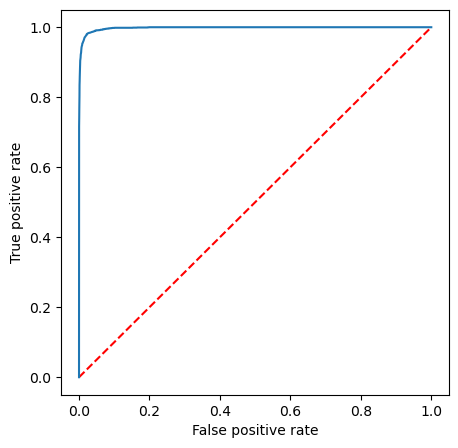

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")
plt.plot(
 lr_model.summary.roc.select("FPR").collect(),
 lr_model.summary.roc.select("TPR").collect(),
)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [270]:
from pyspark.ml.tuning import ParamGridBuilder

grid_search=(
    ParamGridBuilder().addGrid(lr.elasticNetParam, [0.0,0.5,1.0]).build()
)

grid_search

[{Param(parent='LogisticRegression_d7ba205e7224', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_d7ba205e7224', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5},
 {Param(parent='LogisticRegression_d7ba205e7224', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 1.0}]

In [271]:
from pyspark.ml.tuning import CrossValidator

cv=CrossValidator(
    estimator=food_pipeline,
    estimatorParamMaps=grid_search,
    evaluator=evaluator,
    numFolds=3,
    seed=13,
    collectSubModels=True,
)

cv_model=cv.fit(dataset=train)

In [272]:
print(cv_model.avgMetrics)

#gano el 1ro elasticNetParam == 0.0
pipeline_food_model = cv_model.bestModel

[0.9892674879017225, 0.9892698931275343, 0.9892695754050417]


cv.explainParam("estimatorParamMaps")
si se corre k veces y se toma el avg 
se van cambiando pero el param se mantiene fijo las tres veces

hyperparameter tuning
6 veces!

son el promedio!

El mejor es 0.5

In [273]:
pipeline_food_model.write().overwrite().save("dessert_model")

In [280]:
from pyspark.ml.pipeline import PipelineModel

loaded_model = PipelineModel.load("dessert_model")

loaded_model.stages[-1].params

[Param(parent='LogisticRegression_d7ba205e7224', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_d7ba205e7224', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_d7ba205e7224', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_d7ba205e7224', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_d7ba205e7224', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_d7ba205e7224', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_d7ba205e7224', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound cons

In [114]:
from pyspark.ml.feature import Imputer

OLD_COLS = ["calories","protein","fat","sodium"]
NEW_COLS = ["calories_i","protein_i","fat_i","sodium_i"]

#las nuevas van
imputer=Imputer(strategy="mean",inputCols=OLD_COLS,outputCols=NEW_COLS)

In [81]:
imputer_model=imputer.fit(food)

In [86]:
CONTINUOUS = list(set(CONTINUOUS)-set(OLD_COLS)) + NEW_COLS

In [93]:
food_imputed=imputer_model.transform(food)

food_imputed.where("calories is null").select("calories","calories_i").show()
food_imputed.where("calories is not null").select("calories","calories_i").show()

+--------+------------------+
|calories|        calories_i|
+--------+------------------+
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
|    NULL|475.33021591765004|
+--------+------------------+
only showing top 20 rows

+--------+----------+
|calories|calories_i|
+--------+----------+
|   426.0|     426.0|
|   403.0|     403.0|
|   165.0|     165.0|
|   547.0|     547.0|
|   948.0|     948.0|
|   170.0|     170.0|
|   602.0|     602.0|
|   256.0|     256.0|
|   766.0|  

In [100]:



#0-1
#0-range
#-10 10

#porque ya estan de 0 1
#las binarias ya estan 0-1


In [171]:
from pyspark.ml.feature import MinMaxScaler

CONTINUOUS_NB = [x for x in CONTINUOUS if "ratio" not in x]

print(len(CONTINuOUS_NB))

food_features=(
    VectorAssembler(inputCols=CONTINUOUS_NB, outputCol="ale").
    transform(food_imputed)
    #select("ale").show(truncate=False)
)

food_features

#learn the min and max 
ale = (
    MinMaxScaler(inputCol="ale",outputCol="ale_scaled").
    #necesitas este un poco de metadata 
    fit(food_features).
    #calulas la data
    transform(food_features)
)


5


In [167]:
ale

DataFrame[title: string, rating: double, calories: double, protein: double, fat: double, sodium: double, cakeweek: double, wasteless: double, 22_minute_meals: double, 3_ingredient_recipes: double, 30_days_of_groceries: double, advance_prep_required: double, alabama: double, alaska: double, alcoholic: double, almond: double, amaretto: double, anchovy: double, anise: double, anniversary: double, anthony_bourdain: double, aperitif: double, appetizer: double, apple: double, apple_juice: double, apricot: double, arizona: double, artichoke: double, arugula: double, asian_pear: double, asparagus: double, aspen: double, atlanta: double, australia: double, avocado: double, back_to_school: double, backyard_bbq: double, bacon: double, bake: double, banana: double, barley: double, basil: double, bass: double, bastille_day: double, bean: double, beef: double, beef_rib: double, beef_shank: double, beef_tenderloin: double, beer: double, beet: double, bell_pepper: double, berry: double, beverly_hills:

ML Pipeline

In [139]:
#this are scaled by column!
#si estan por columnas!
df = ale.select("ale_scaled").to_pandas_on_spark()

/usr/local/spark/python/pyspark/sql/dataframe.py:5719: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


In [146]:
df.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 20048 entries, 0 to 20047
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ale_scaled  20048 non-null  object
dtypes: object(1)

In [154]:
scaled = pd.DataFrame(df["ale_scaled"].to_list())

/usr/local/spark/python/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [165]:

for i in scaled.columns:
    print("Col", i, "Min:", scaled[i].min(), "Max:", scaled[i].max())

Col 0 Min: 0.0 Max: 1.0
Col 1 Min: 0.0 Max: 1.0
Col 2 Min: 0.0 Max: 1.0
Col 3 Min: 0.0 Max: 1.0
Col 4 Min: 0.0 Max: 0.9999999999999999


In [168]:
ale

DataFrame[title: string, rating: double, calories: double, protein: double, fat: double, sodium: double, cakeweek: double, wasteless: double, 22_minute_meals: double, 3_ingredient_recipes: double, 30_days_of_groceries: double, advance_prep_required: double, alabama: double, alaska: double, alcoholic: double, almond: double, amaretto: double, anchovy: double, anise: double, anniversary: double, anthony_bourdain: double, aperitif: double, appetizer: double, apple: double, apple_juice: double, apricot: double, arizona: double, artichoke: double, arugula: double, asian_pear: double, asparagus: double, aspen: double, atlanta: double, australia: double, avocado: double, back_to_school: double, backyard_bbq: double, bacon: double, bake: double, banana: double, barley: double, basil: double, bass: double, bastille_day: double, bean: double, beef: double, beef_rib: double, beef_shank: double, beef_tenderloin: double, beer: double, beet: double, bell_pepper: double, berry: double, beverly_hills:

ml pipeline is an ordered list of 